In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2DTranspose, Conv2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import time


import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


# Load the MNIST data
We want to generate numbers and we dont care which number. Therefor we olny want the training images

In [12]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

In [13]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(64)

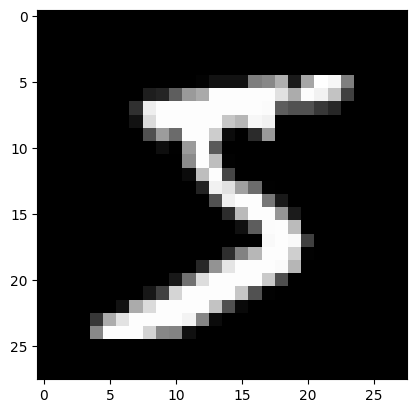

In [15]:
for batch in train_dataset:
    plt.imshow(batch[0], cmap='gray')
    break

# Generator model

In [16]:
def build_generator(noise_dim):
    model = Sequential()

    model.add(Dense(64 * 7 * 7, activation="relu", input_dim=noise_dim))
    model.add(Reshape((7, 7, 64)))
    model.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"))
    model.add(Activation("sigmoid"))
    model.add(Conv2DTranspose(16, kernel_size=4, strides=2, padding="same"))
    model.add(Activation("sigmoid"))
    model.add(Conv2D(1, kernel_size=4, padding="same"))
    model.add(Activation("tanh"))

    return model

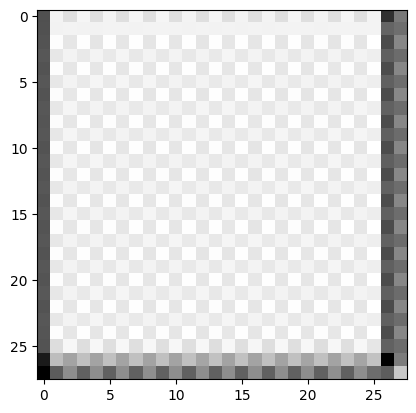

In [17]:
generator = build_generator(20)

noise = tf.random.normal([1, 20])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0], cmap='gray')

In [18]:
generated_image.shape

TensorShape([1, 28, 28, 1])

# Dicriminator model

In [19]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=image_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [20]:
discriminator = build_discriminator((28,28,1))
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49990886]], shape=(1, 1), dtype=float32)


# Loss functions and optimizers

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
# We create the labels in the loss function.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def generator_loss(fake_output):
    # We want the dicriminator to think all fake images are correct.
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Train the models

In [25]:
@tf.function
def train_step(images, noise_dim):
    noise = tf.random.normal([64, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Set batchsize and number of generated exampels to the same number
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [26]:
def show_generated_image(generator, noise_dim):
    # Generate random noise as input
    noise = np.random.normal(0, 1, (1, noise_dim))

    # Generate an image from the noise
    generated_image = generator.predict(noise)[0]

    # Plot the generated image
    plt.imshow(generated_image, cmap='gray')
    plt.axis('off')
    plt.show()

In [27]:
def train(dataset, epochs, noise_dim):
    for epoch in range(epochs):
        start = time.time()
    
        for image_batch in dataset:
            train_step(image_batch, noise_dim)
        
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
        # Show generated image
        show_generated_image(generator, noise_dim)


/Users/joeloscarsson/Documents/www/DeepLearning/deeplearning/lib/python3.9/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 1 is 137.23265099525452 sec
1/1 [==============================] - 0s 134ms/step


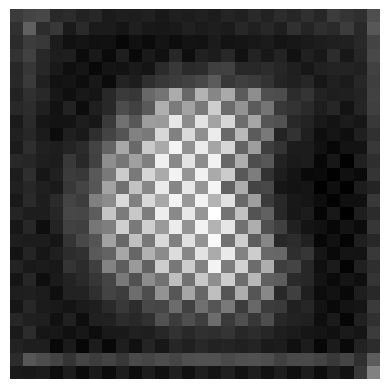

Time for epoch 2 is 129.71173882484436 sec
1/1 [==============================] - 0s 33ms/step


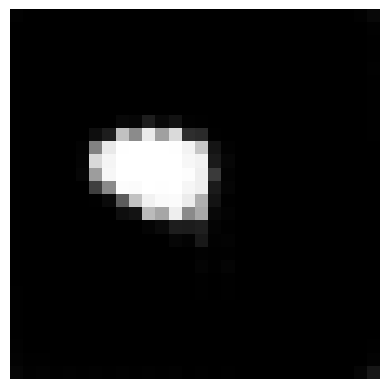

Time for epoch 3 is 120.73162579536438 sec
1/1 [==============================] - 0s 28ms/step


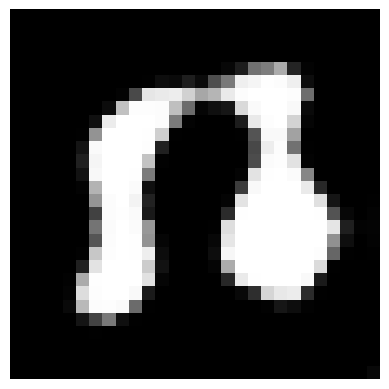

Time for epoch 4 is 119.8797619342804 sec
1/1 [==============================] - 0s 30ms/step


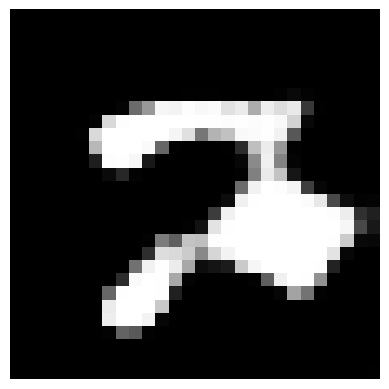

Time for epoch 5 is 124.90027904510498 sec
1/1 [==============================] - 0s 32ms/step


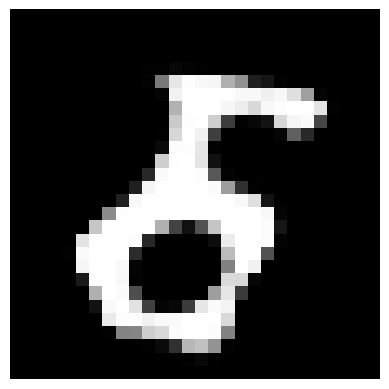

Time for epoch 6 is 128.50110697746277 sec
1/1 [==============================] - 0s 31ms/step


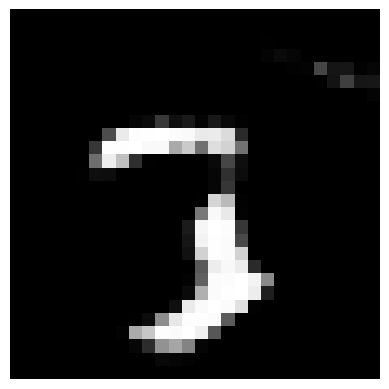

Time for epoch 7 is 126.5304069519043 sec
1/1 [==============================] - 0s 32ms/step


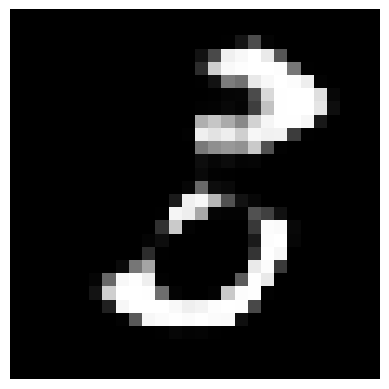

Time for epoch 8 is 133.41940903663635 sec
1/1 [==============================] - 0s 28ms/step


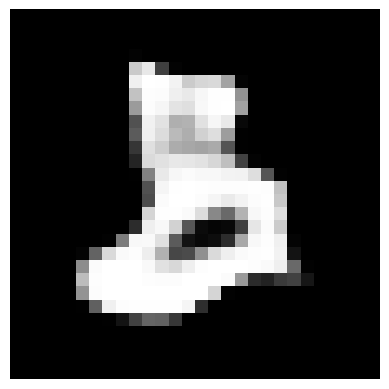

Time for epoch 9 is 125.06303787231445 sec
1/1 [==============================] - 0s 28ms/step


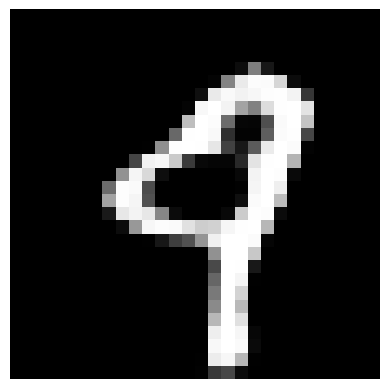

Time for epoch 10 is 123.70110607147217 sec
1/1 [==============================] - 0s 31ms/step


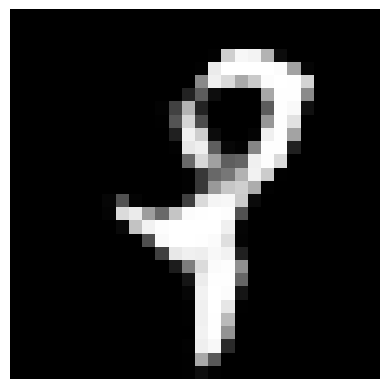

Time for epoch 11 is 122.07331681251526 sec
1/1 [==============================] - 0s 27ms/step


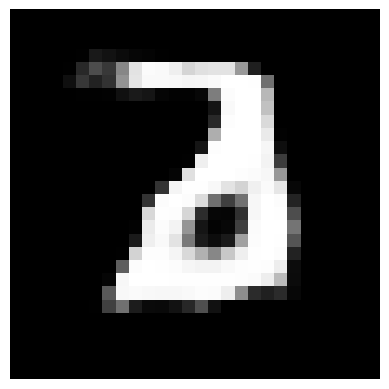

Time for epoch 12 is 121.44615769386292 sec
1/1 [==============================] - 0s 32ms/step


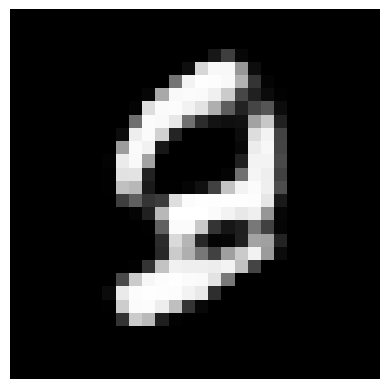

Time for epoch 13 is 120.17399287223816 sec
1/1 [==============================] - 0s 28ms/step


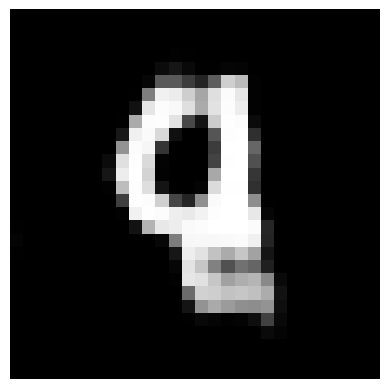

Time for epoch 14 is 124.10045289993286 sec
1/1 [==============================] - 0s 27ms/step


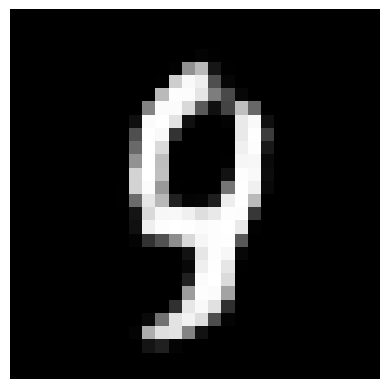

Time for epoch 15 is 124.93102383613586 sec
1/1 [==============================] - 0s 30ms/step


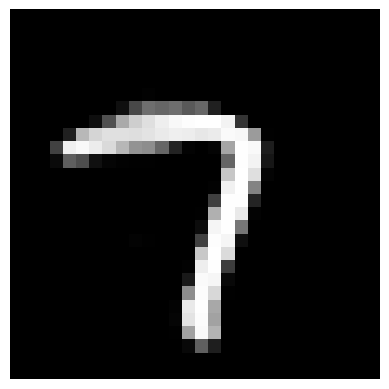

Time for epoch 16 is 127.27986001968384 sec
1/1 [==============================] - 0s 30ms/step


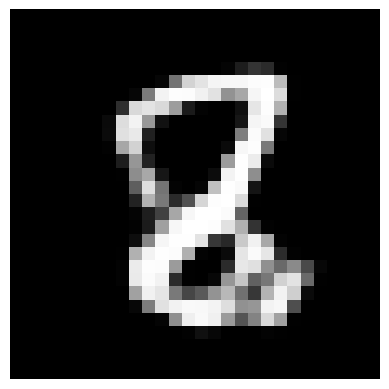

Time for epoch 17 is 127.45590400695801 sec
1/1 [==============================] - 0s 29ms/step


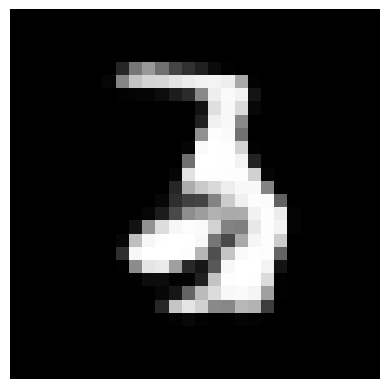

Time for epoch 18 is 122.15581893920898 sec
1/1 [==============================] - 0s 28ms/step


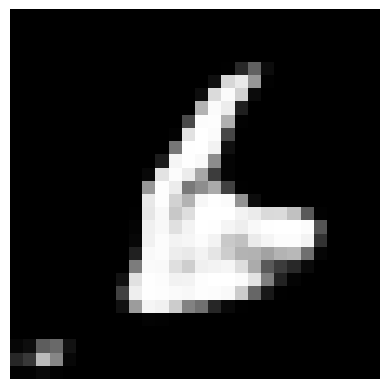

Time for epoch 19 is 121.81511807441711 sec
1/1 [==============================] - 0s 29ms/step


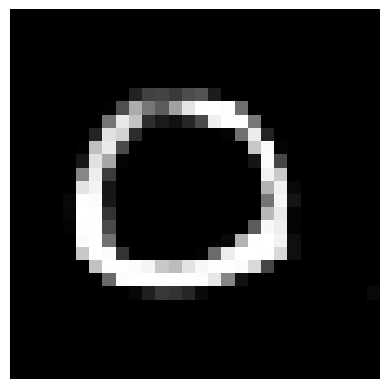

Time for epoch 20 is 122.11991620063782 sec
1/1 [==============================] - 0s 28ms/step


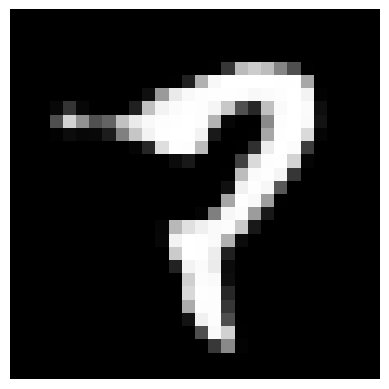

Time for epoch 21 is 121.50412201881409 sec
1/1 [==============================] - 0s 29ms/step


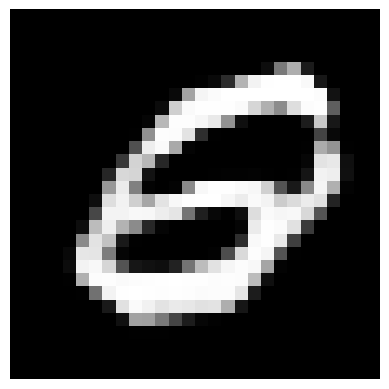

Time for epoch 22 is 121.54360508918762 sec
1/1 [==============================] - 0s 29ms/step


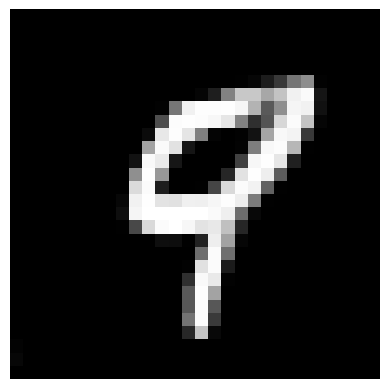

Time for epoch 23 is 121.65408110618591 sec
1/1 [==============================] - 0s 28ms/step


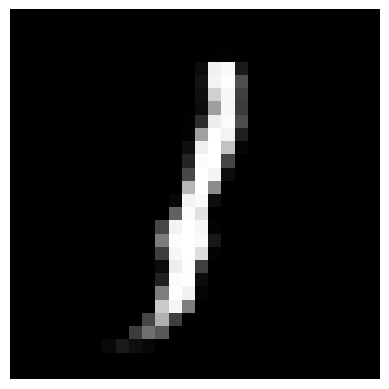

Time for epoch 24 is 120.82977390289307 sec
1/1 [==============================] - 0s 29ms/step


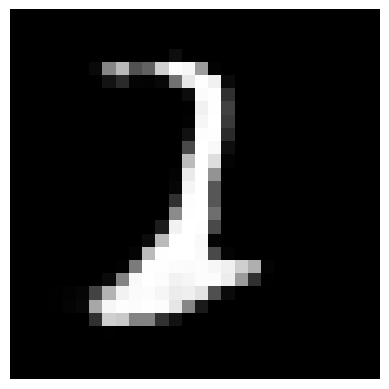

Time for epoch 25 is 121.52066111564636 sec
1/1 [==============================] - 0s 28ms/step


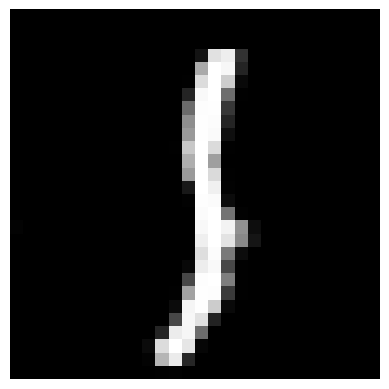

Time for epoch 26 is 121.72568893432617 sec
1/1 [==============================] - 0s 30ms/step


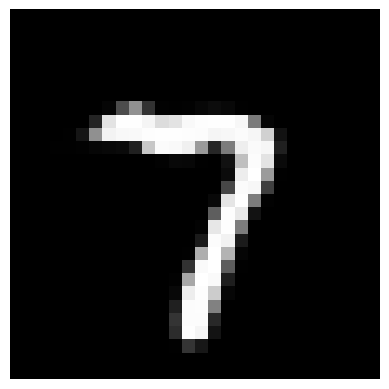

Time for epoch 27 is 121.69264507293701 sec
1/1 [==============================] - 0s 27ms/step


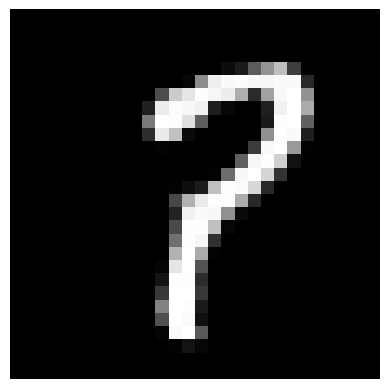

Time for epoch 28 is 120.76782321929932 sec
1/1 [==============================] - 0s 27ms/step


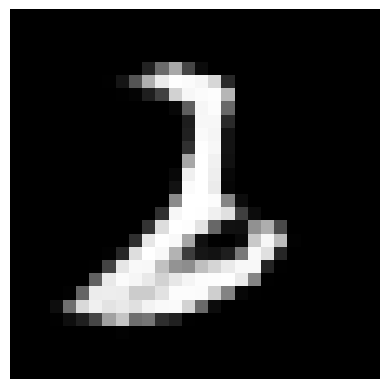

Time for epoch 29 is 121.06273579597473 sec
1/1 [==============================] - 0s 29ms/step


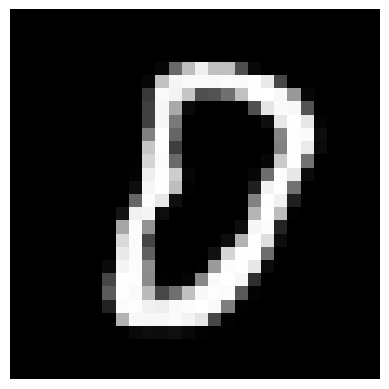

Time for epoch 30 is 120.87971997261047 sec
1/1 [==============================] - 0s 28ms/step


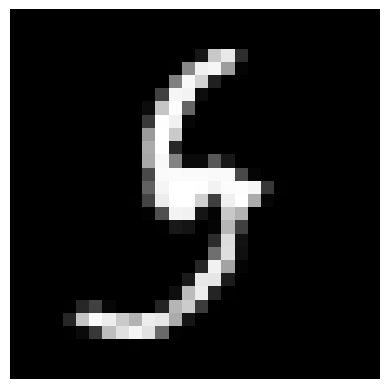

Time for epoch 31 is 122.52890586853027 sec
1/1 [==============================] - 0s 29ms/step


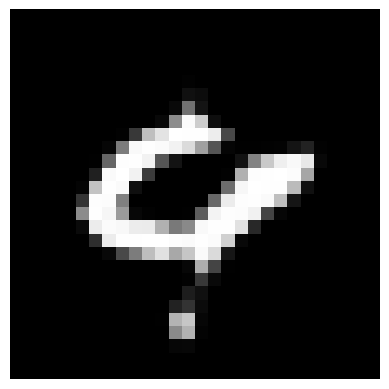

Time for epoch 32 is 121.9723629951477 sec
1/1 [==============================] - 0s 28ms/step


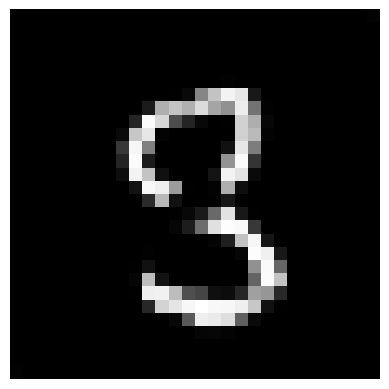

Time for epoch 33 is 121.81492495536804 sec
1/1 [==============================] - 0s 29ms/step


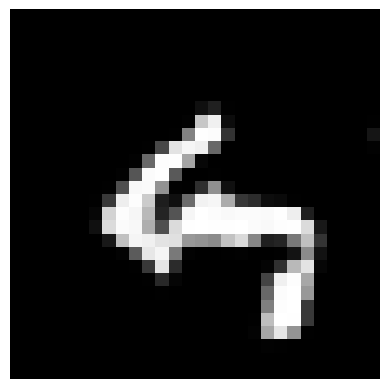

Time for epoch 34 is 121.58452773094177 sec
1/1 [==============================] - 0s 30ms/step


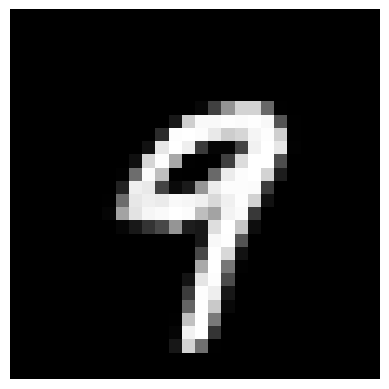

Time for epoch 35 is 121.34669780731201 sec
1/1 [==============================] - 0s 28ms/step


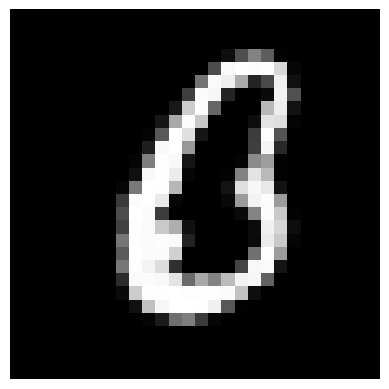

Time for epoch 36 is 121.81386113166809 sec
1/1 [==============================] - 0s 29ms/step


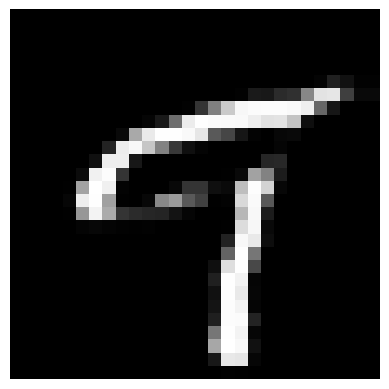

Time for epoch 37 is 127.76049304008484 sec
1/1 [==============================] - 0s 29ms/step


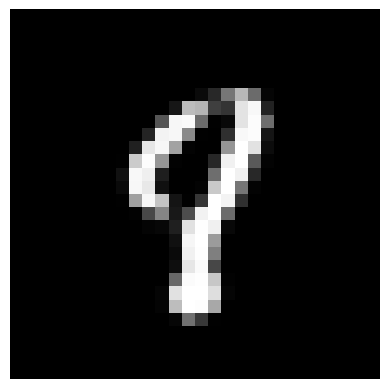

KeyboardInterrupt: 

In [28]:
train(train_dataset, 50, 20)

# Tasks
Change the model architectures and try to generate as good images as possible.

Remember to not only change the generator. If the discriminator gets better, the generator need to generate better images.